**Overview -** Demonstrating Unsupervised ML<br>
**Task -** From the given ‘Iris’ dataset, predict the optimum number of clusters
and represent it visually.<br>
**Data Link -**https://bit.ly/3kXTdox <br>

## 1. Importing Libraries

In [1]:
#Data Manipulation Libraries
import pandas as pd
import numpy as np

#Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn & Scipy Libraries 
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

#Miscellaneous libraries
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 2. Data Understanding

In [2]:
#Reading the Dataset
df = pd.read_csv("Iris.csv")

In [3]:
#checking top few rows
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
#count if each species
df.groupby('Species').size()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64

In [5]:
#Checking the Metadata Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


- From above we infer following things
    - Id is the unique column which identifies each unique type of irises.
    - There are no Null valuesin the dataset, hence data is clean.
    - Species, is our target variable.
    - We are given the Sepal and Petal length & width which are having float data type and of similar Magnitude.

In [6]:
#checking how data is spread
df.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


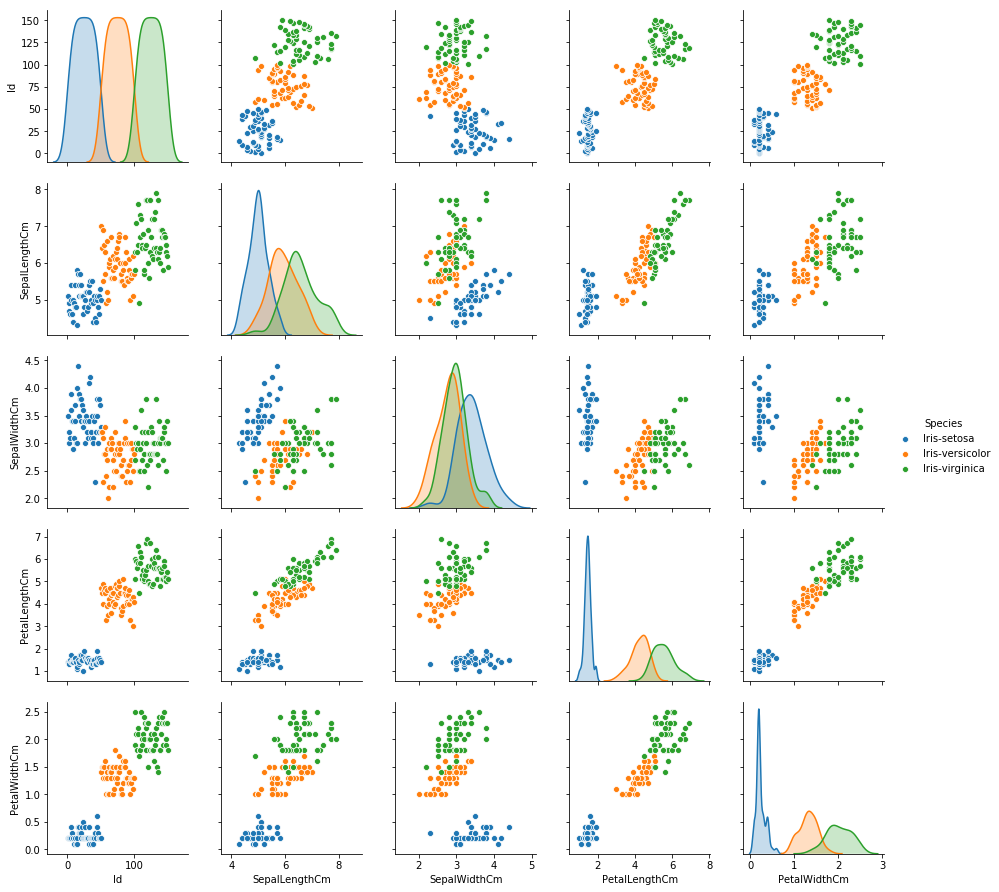

In [7]:
#Visualizing data and how each othem are correlated
sns.pairplot(df,hue = 'Species')

- From above graph we infer following things 
  1. we can clearly see that there are 3 cluster formation and in each graph we see three gaussian curves.
  2. We also see that few data points overlaps,so we will try the following algorithms - **KMeans, Hierarchical Clustering and DBScan.**

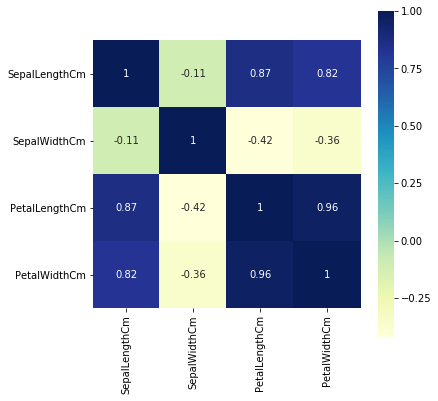

In [8]:
#Correlation
plt.figure(figsize=(6,6))
corrmat = df.drop('Id',axis=1).corr()
sns.heatmap(corrmat, annot = True, square = True,cmap ='YlGnBu')
plt.show()

- The main takeaway is that the petal measurements have highly positive correlation, while the sepal one are uncorrelated

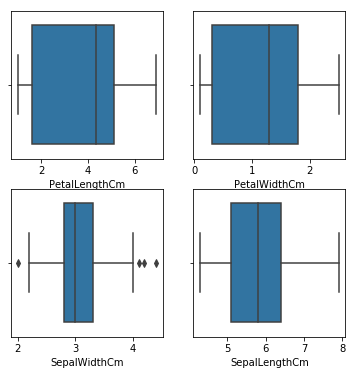

In [9]:
## checking for Outliers, as we know that Kmeans is susceptible to outliers
cols = set(df.columns) -{'Id','Species'}
count=1
plt.subplots(figsize=(6, 6))
for i in cols:
    plt.subplot(2,2,count)
    sns.boxplot(df[i])
    count+=1
plt.show()

- We see few outliers in Sepal Width, initially lets try to proceed with these outliers.

## 3. Data Modeling

In [10]:
#We will drop ID column as its unique and separate dependent and independent variable.
X = df.drop(['Id', 'Species'], axis=1)
y = df['Species']
#checking shape of the data
print(X.shape)
#checking shape of the target variable
print(y.shape)

(150, 4)
(150,)


## 4. Hopkin Test
As we checked previously the dataset looks of similar magnitude. Hence no further standardisation is necessary. Let's proceed to calculating the Hopkins statistic to ensure that the data is good for clustering.

In [11]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [12]:
#Let's check the Hopkins measure
hopkins(X)

0.8408778161057399

- 0.83 is a good Hopkins score. Hence the data is suitable for clustering. Preliminary check is now done.

## 5. Clustering Algorithms

### <a> 5.1 KMeans Clustering

In [13]:
kmeans = KMeans(n_clusters=5)
y_kmeans = kmeans.fit_predict(X)
print(y_kmeans)

kmeans.cluster_centers_

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 0 3 0 3 0 3 0 0 0 0 3 0 3 0 0 3 0 3 0 3 3
 3 3 3 3 3 0 0 0 0 3 0 3 3 3 0 0 0 3 0 0 0 0 0 3 0 0 4 3 2 4 4 2 0 2 4 2 4
 4 4 3 4 4 4 2 2 3 4 3 2 3 4 2 3 3 4 2 2 2 4 3 3 2 4 4 3 4 4 4 3 4 4 4 3 4
 4 3]


array([[5.53214286, 2.63571429, 3.96071429, 1.22857143],
       [5.006     , 3.418     , 1.464     , 0.244     ],
       [7.475     , 3.125     , 6.3       , 2.05      ],
       [6.24722222, 2.84722222, 4.775     , 1.575     ],
       [6.52916667, 3.05833333, 5.50833333, 2.1625    ]])

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [14]:
## Lets apply silhouette analysis
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(X)
    sse_.append([k, silhouette_score(X, kmeans.labels_)])

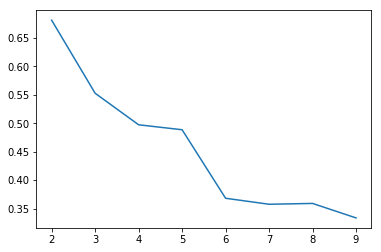

In [15]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

- The sihouette score reaches a peak at around 3 clusters, starting from 2 clusters, indicating that it might be the ideal number of clusters.

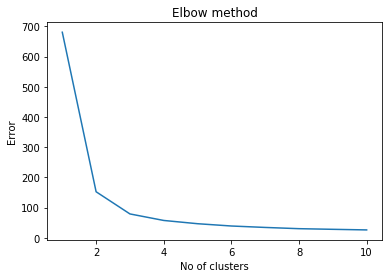

In [16]:
#Let's use the elbow curve method to identify the ideal number of clusters.

Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

- A distinct elbow is formed at around 3-10 clusters. Let's finally create the clusters and see for ourselves which ones fare better
- K-means with k=3 clusters

In [17]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(X)

KMeans(max_iter=50, n_clusters=3)

In [18]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2])

In [19]:
# assign the label
X_grouped = X.copy()
X_grouped['cluster_id'] = kmeans.labels_
X_grouped.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,cluster_id
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [20]:
#Checking how many data points are assigned to each cluster-ids
X_grouped['cluster_id'].value_counts()

2    62
1    50
0    38
Name: cluster_id, dtype: int64

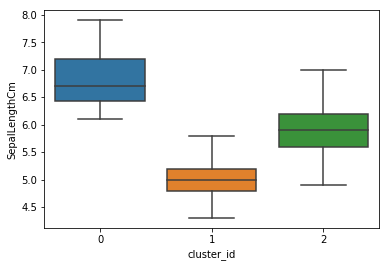

In [21]:
# Box plot for Cluster id Versus Sepal Length
sns.boxplot(x='cluster_id', y='SepalLengthCm', data=X_grouped)

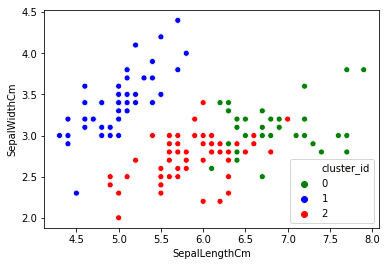

In [22]:
# Scatter plot for Sepal Length Versus Sepal Width
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', hue ='cluster_id',data=X_grouped,palette = ['green','blue','red'])

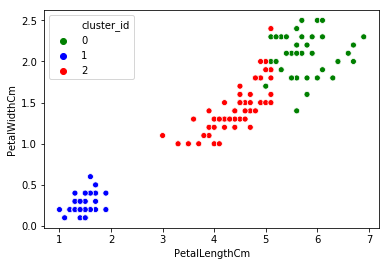

In [23]:
# Scatter plot for Petal Length Versus Petal Width
sns.scatterplot(x='PetalLengthCm', y='PetalWidthCm', hue ='cluster_id',data=X_grouped,palette = ['green','blue','red'])

*__Conclusion(KMeans) - We see that using Kmeans with 3 clusters has given the good data seggregation. Lets use other clustering techniques to see is there any variation.__*

## <a>3.2 Hierarchical Clustering

Hierarchical clustering treats each data point as a singleton cluster, and then successively merges clusters until all points have been merged into a single remaining cluster. A hierarchical clustering is often represented as a dendrogram 

**In complete-link (or complete linkage) hierarchical clustering**, we merge in each step the two clusters whose merger has the smallest diameter (or: the two clusters with the smallest maximum pairwise distance).

**In single-link (or single linkage) hierarchical clustering**, we merge in each step the two clusters whose two closest members have the smallest distance (or: the two clusters with the smallest minimum pairwise distance).

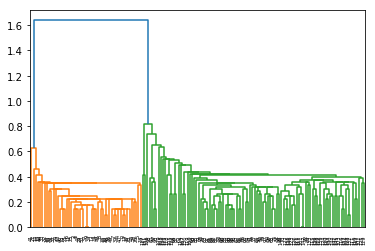

In [24]:
# single linkage
mergings = linkage(X, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

In [25]:
# From above we identified 3 clusters
cluster_labels_single = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels_single

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [26]:
# assign cluster labels
X_grouped['cluster_labels_single'] = cluster_labels_single
X_grouped.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,cluster_id,cluster_labels_single
0,5.1,3.5,1.4,0.2,1,0
1,4.9,3.0,1.4,0.2,1,0
2,4.7,3.2,1.3,0.2,1,0
3,4.6,3.1,1.5,0.2,1,0
4,5.0,3.6,1.4,0.2,1,0


In [27]:
#Checking how many data points are assigned to each cluster-ids
X_grouped['cluster_labels_single'].value_counts()

1    98
0    50
2     2
Name: cluster_labels_single, dtype: int64

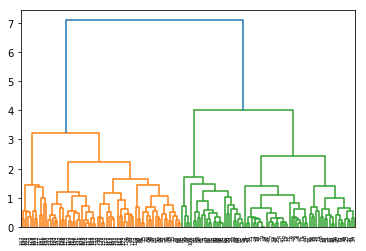

In [28]:
# complete linkage
mergings = linkage(X, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [29]:
# From above we identified 3 clusters
cluster_labels_complete = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels_complete

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [30]:
# assign cluster labels
X_grouped['cluster_labels_complete'] = cluster_labels_complete
X_grouped.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,cluster_id,cluster_labels_single,cluster_labels_complete
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [31]:
#Checking how many data points are assigned to each cluster-ids
X_grouped['cluster_labels_complete'].value_counts()

1    72
0    50
2    28
Name: cluster_labels_complete, dtype: int64

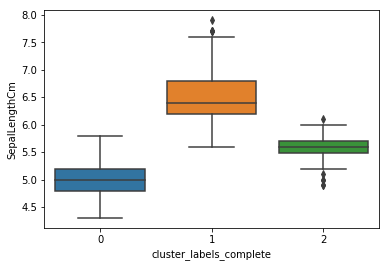

In [32]:
# Box plot for Cluster id Versus Sepal Length
sns.boxplot(x='cluster_labels_complete', y='SepalLengthCm', data=X_grouped)

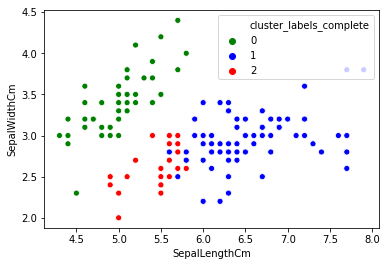

In [33]:
# Scatter plot for Sepal Length Versus Sepal Width
sns.scatterplot(x='SepalLengthCm', y='SepalWidthCm', hue ='cluster_labels_complete',data=X_grouped,palette = ['green','blue','red'])

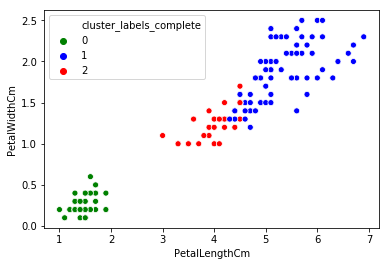

In [34]:
# Scatter plot for Petal Length Versus Petal Width
sns.scatterplot(x='PetalLengthCm', y='PetalWidthCm', hue ='cluster_labels_complete',data=X_grouped,palette = ['green','blue','red'])

## <a> 3.3 DBScan
- Before Proceeding let me give some brief idea about DBScan.
    - DBscan stands for “density based spatial clustering of applications with noise”.
    - It does not require the user to set the number of clusters a priori.
    - It can capture clusters of complex shapes.
    - It can identify points that are not part of any cluster **(very useful as outliers detector)**
    - It is somewhat slower than agglomerative clustering and k-means, but still scales to relatively large datasets.
    - It works by identifying points that are in crowded regions of the feature space, where many data points are close   
      together (dense regions in feature space)
    - Points that are within a dense region are called core samples (or core points)
    - There are two parameters in DBSCAN: min_samples and eps
    - If there are at least min_samples many data points within a distance of eps to a given data point, that data point is       classified as a core sample
    - The core samples that are closer to each other than the distance eps are put into the same cluster by DBSCAN.

- The parameter eps is somewhat more important, as it determines what it means for points to be close. 
- Setting eps to be very small will mean that no points are core samples, and may lead to all points being labeled as noise. 
- Setting eps to be very large will result in all points forming a single cluster.

Text(0, 0.5, 'Feature 1')

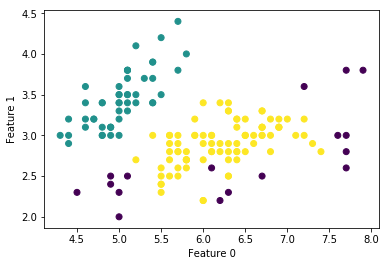

In [35]:
# cluster the data into three clusters
dbscan = DBSCAN()
clusters = dbscan.fit_predict(X)
# plot the cluster assignments
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [36]:
# assign cluster labels
X_grouped['cluster_labels_dbscan'] = clusters
#Checking how many data points are assigned to each cluster-ids
X_grouped['cluster_labels_dbscan'].value_counts()

 1    84
 0    49
-1    17
Name: cluster_labels_dbscan, dtype: int64

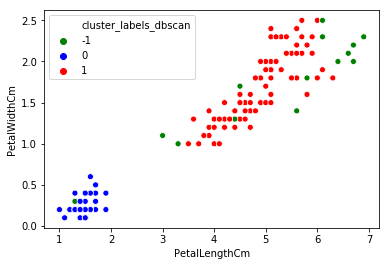

In [37]:
# Scatter plot for Petal Length Versus Petal Width
sns.scatterplot(x='PetalLengthCm', y='PetalWidthCm', hue ='cluster_labels_dbscan',data=X_grouped,palette = ['green','blue','red'])

- DBSCAN Found only 2 clusters and one Noise 

- We saw different features and there are only few data points with overlap. Since this dataset is simple so we are not able to see much difference. If we have non-linear data or spiral shapes then we can clearly see that DBScan would be the winner

## 6. Predicting the Data

### <a> 6.a Prediction

In [38]:
#Kmeans prediction
y_pred_kmeans = kmeans.predict(X)

#Hierarchical Clustering 
y_pred_hierarchical = cut_tree(mergings, n_clusters=3).reshape(-1, )

#DBScan Prediction
y_pred_dbscan = dbscan.fit_predict(X)

### <a>6.b Checking ARI
The Adjusted Rand Index (ARI) is frequently used in cluster validation since it is a measure of agreement between two partitions: one given by the clustering process and the other defined by external criteria.

In [39]:
from sklearn.metrics.cluster import adjusted_rand_score
#k-means performance:
print("ARI =", adjusted_rand_score(y, y_pred_kmeans))

#Hierarchical clustering performance
print("ARI =", adjusted_rand_score(y, y_pred_hierarchical))

#DBSCAN performance:
print("ARI =", adjusted_rand_score(y, y_pred_dbscan))


ARI = 0.7302382722834697
ARI = 0.64225125183629
ARI = 0.5206185241703302


## 7. Final Conclusion

- We used all Algorithms - KMeans, Hierarchical and DBScan. Overall KMeans is the perfect for this data as this data is linear in nature.
- In Step-6 we calculated the performance of each algorithm, **Clearly KMeans performed Best with ARI of 73.**